In [1]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 2.7.6
IPython 5.2.2

tensorflow 1.0.0
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [2]:
import tensorflow as tf
import numpy as np
import os
print(tf.__version__)

1.0.0


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import jieba
from jieba import posseg as pseg
from collections import defaultdict, Counter
import random
import time

In [4]:
NEG = 'N'
POS = 'P'

train_files = {}
train_files[NEG] = 'neg_train.txt'
train_files[POS] = 'pos_train.txt'

test_files = {}
test_files[NEG] = 'neg_test.txt'
test_files[POS] = 'pos_test.txt'

In [5]:
#读取文件，分词
def load_file(file_name, line_num=0):
    f = open(file_name, 'r')    
    lines = f.readlines()
    cnt = len(lines)
    if line_num >0:
        cnt = line_num
    f.close()
    segs = []
    seg_lines = []
    for line in lines[:cnt]:
        line = line.strip()
        words = pseg.cut(line)
        seg_per_line = []
        for (key, flag) in words:
            if flag == 'x':
                continue           
            segs.append(key)
            seg_per_line.append(key)
        seg_lines.append(seg_per_line)
    return segs, seg_lines

In [6]:
def load_train_dataset(input_data, line_num=0):
    segs = {}
    seg_lines = {}
    for k, v in input_data.items():
         segs[k], seg_lines[k] = load_file(v, line_num)
    return segs, seg_lines

In [7]:
t0 = time.time()

segs_dict, seg_lines_dict = load_train_dataset(train_files)

t1 = time.time()
print(t1-t0)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.301 seconds.
Prefix dict has been built succesfully.


146.244341135


In [8]:
print(len(segs_dict[NEG]))
print(len(segs_dict[POS]))
print(len(seg_lines_dict[NEG]))
print(len(seg_lines_dict[POS]))

449708
508469
13003
11583


In [9]:
UNKNOWN_WORD = u'UNK'

In [10]:
#建立vocabulary dict
def build_word_dict(input_segs):
    all_segs = []
    temp = []
    for (k, v) in input_segs.items():
        all_segs.extend(v)
    word_cnt = Counter(all_segs)
    word_dict = {}
    word_dict[UNKNOWN_WORD] = 0
    index_dict = {}
    index_dict[0] = UNKNOWN_WORD
    i = 1
    for (k, v) in word_cnt.most_common()[:4999]:
        word_dict[k] = i
        index_dict[i] = k
        i += 1
    return word_dict, index_dict

In [11]:
all_word_dict, all_index_dict = build_word_dict(segs_dict)

In [12]:
print(len(all_word_dict))
print(len(all_index_dict))

5000
5000


In [13]:
#把语句转换为词索引
def build_line_data(lines, word_dict, isTestdata=False):
    lines_index = {}
    labels_index = {}
    i = 0
    max_len = 0
    for (k,v) in lines.items():
        label = 0
        if (k==POS):
            label = 1
        for line in v:
            seg_index = []
            labels_index[i] = label            
            for word in line:
                if isTestdata:                    
                    if word in word_dict.keys():
                        seg_index.append(word_dict[word])
                    else:
                        seg_index.append(0)
                else:
                    seg_index.append(word_dict[word])
            lines_index[i] = seg_index
            if (max_len < len(seg_index)):
                max_len = len(seg_index)                
            i+=1
    return max_len, lines_index, labels_index

In [14]:
max_sentence_len, train_sentences, train_labels = build_line_data(seg_lines_dict, all_word_dict, True)

In [15]:
print(max_sentence_len)
print(len(train_sentences))
print(len(train_labels))

i=0
#句子长度设为60，训练语料中80%句子长度小于60
SENTENCE_LEN=60

for (k,s) in train_sentences.items():
    
    if len(s)<=SENTENCE_LEN:
        i+=1

total_sentence = len(train_sentences)
print i
outsider = total_sentence - i
print outsider
print 100.0 * outsider / total_sentence

1479
24586
24586
19568
5018
20.4099894249


In [16]:
#把每行语料变成固定长度，短句后面补未命中词，长句直接截断
def build_input_train_data(sentences, max_len):
    input_ = {}
    for (k,v) in sentences.items():
        input_[k] = v[:max_len]
        if (len(v) < max_len):
            padding = [0] *(max_len-len(v))
            input_[k].extend(padding)
    return input_

In [17]:
input_train_data = build_input_train_data(train_sentences, SENTENCE_LEN)

In [18]:
print len(input_train_data)
for (k,v) in input_train_data.items()[:2]:
    print k, len(v), v
    s = ''
    for w in v:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

24586
0 60 [121, 2, 457, 88, 62, 15, 522, 1580, 21, 1, 142, 127, 121, 1, 409, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
装 了 xp 系统 后 没有 出现 网友 说 的 驱动 不好 装 的 情况 
1 60 [829, 32, 211, 76, 421, 5, 17, 1031, 1683, 1517, 3939, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
总的来说 比较 干净 而且 地理位置 很 好 市区 繁华 地段 进出 方便 


In [19]:
#读入测试语料
t0 = time.time()
test_segs, test_lines = load_train_dataset(test_files,1000)
t1 = time.time()
print(t1-t0)

12.0676429272


In [20]:
t0 = time.time()
s_len, test_sentences, test_labels = build_line_data(test_lines, all_word_dict,isTestdata=True)
t1 = time.time()
print(t1-t0)

9.50440406799


In [21]:
print(s_len)
print(len(test_sentences))
print(len(test_labels))

692
2000
2000


In [22]:
input_test_data = build_input_train_data(test_sentences, SENTENCE_LEN)

In [24]:
vocab_size = len(all_word_dict)
word_embed_size = 64

print(vocab_size)

5000


In [62]:
def get_all_test_data(data, labels):
    output_ = []
    labels_ = []
    for (k,v) in data.items():
        output_.append(v)
    for (k,v) in labels.items():
        labels_.append(v)
    return output_, get_label_matrix(labels_, 2)

In [64]:
input_test_data_list, test_labels_list = get_all_test_data(input_test_data, test_labels)
print(len(input_test_data_list))
print(input_test_data_list[0])
print(test_labels_list[0])

2000
[3187, 0, 638, 2, 399, 269, 199, 0, 967, 42, 4, 128, 1059, 1, 697, 691, 535, 286, 278, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1]


In [25]:
def shuffle_data(input_data, input_labels):
    output_data = []
    for (index,v) in input_data.items():
        label = input_labels[index]
        output_data.append((index, label, v))
    np.random.shuffle(output_data)
    return output_data

In [26]:
#对输入数据作shuffle处理
shuffled_train_data = shuffle_data(input_train_data, train_labels)
shuffled_test_data = shuffle_data(input_test_data, test_labels)

print(len(shuffled_train_data))
print(len(shuffled_test_data))

24586
2000


In [27]:

for (i, k,v) in shuffled_test_data[:5]:
    print i, k, v
    s = ''
    for w in v:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

428 1 [191, 18, 295, 14, 222, 19, 0, 1307, 1, 0, 18, 0, 1, 125, 502, 397, 439, 4476, 830, 18, 711, 830, 1054, 533, 1, 0, 8, 4, 2139, 0, 71, 338, 4, 101, 155, 56, 288, 0, 0, 4157, 0, 203, 769, 1, 39, 858, 533, 313, 0, 55, 0, 96, 648, 960, 101, 155, 3, 0, 441, 0]
外观 和 做工 还 算 不错 档次 的 和 的 东西 不少 如 显卡 切换 功能 和 指纹 功能 等等 送货 的 在 我 拆 时 告诉 我 如果 里面 不是 电脑 砸 挺 可爱 的 但 快递 送货 人员 他 把 货 送到 如果 里面 是 或 
1599 0 [23, 3, 2216, 3441, 834, 53, 9, 1, 698, 968, 82, 16, 70, 1431, 9, 961, 669, 1499, 29, 35, 2162, 29, 0, 260, 135, 342, 102, 51, 12, 2506, 2, 135, 3018, 2426, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
我们 是 今年 五一 期间 入住 酒店 的 标间 卫生 一般 房间 有点 异味 酒店 对面 有个 超市 要 买 东东 要 好像 晚上 8 点 多 就 关门 了 晚上 路边 小吃 很多 
1502 0 [161, 1, 82, 345, 15, 1050, 7, 197, 35, 35, 2, 6, 7, 197, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
写 的 一般 完全 没有 价值 不 值得 买 买 了 也 不 值得 看 
594 1 [4, 193, 510, 514, 2892, 0, 1, 83

In [28]:
#将label变成one-hot matrix格式
def get_label_matrix(input_label, num_l):
    out_ = []
    for label in input_label:
        line = [0] * num_l
        line[label] = 1
        out_.append(line)    
    return out_

In [29]:
#获取单批训练/测试数据
def get_batch_data(input_data, index, size, num_l):
    data_ = []
    labels_ = []
    indexs_ = []
    for (i, k,v) in input_data[index:index+size]:
        data_.append(v)
        labels_.append(k)
        indexs_.append(i)
    return indexs_, data_, get_label_matrix(labels_, num_l)

In [30]:
i_, d_,l_ = get_batch_data(shuffled_train_data, 1, 5, 2)


print d_
print l_
for d in d_:
    s = ''
    for w in d:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

[[76, 0, 26, 0, 8, 25, 9, 155, 2820, 0, 0, 6, 3, 2688, 1176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1657, 0, 3388, 2878, 1, 125, 4520, 1, 7, 0, 3543, 902, 3293, 516, 667, 10, 0, 178, 132, 14, 24, 512, 138, 1046, 178, 206, 1415, 228, 1038, 56, 5, 2538, 1541, 380, 66, 167, 26, 183, 172, 1, 25, 6, 337, 127, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [711, 14, 57, 2132, 99, 39, 72, 169, 56, 1438, 80, 5, 2296, 0, 0, 1, 4396, 178, 3505, 22, 1132, 2, 151, 1575, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [533, 184, 272, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [424, 46, 3083, 49, 101, 849, 0, 389, 80, 581, 95, 941, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [32]:
tf.reset_default_graph()

In [33]:
tf.reset_default_graph()

graph = tf.Graph()
sentence_length = SENTENCE_LEN
# max_pool
with graph.as_default():
    filter_num = 64
    window_size = 3
    num_labels = 2
    num_fc_hidden = 10
    
    tf_input_data = tf.placeholder(tf.int32, shape=[None, sentence_length], name='input_data')    
    tf_labels = tf.placeholder(tf.int32, shape=[None, num_labels], name='labels')
    
    word_embeds = tf.Variable(tf.random_uniform([vocab_size, word_embed_size], -1.0, 1.0), name="Word_embed")
    input_embeds = tf.nn.embedding_lookup(word_embeds, tf_input_data)
   
    tf_embeds_expand = tf.expand_dims(input_embeds, -1)
    
    print(tf_input_data)
    print(tf_labels)
    print(input_embeds)
    print(tf_embeds_expand)

    filter_shape = [window_size, word_embed_size, 1, filter_num]
    # W 和 b 是卷积的参数
    W = tf.Variable(tf.random_uniform(filter_shape, -1.0, 1.0), name="W")
    # bias 和 filter_num 个数是一样的
    b = tf.Variable(tf.constant(0.0, shape=[filter_num]), name="b")
    # 步长为1，这里不做 Padding，因此句子太短的话可能要丢掉。可自行尝试加 padding（不加也不影响作业评分）
    conv = tf.nn.conv2d(
                    tf_embeds_expand,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
    # 卷积出来的结果加上 bias
    conv_hidden = tf.nn.tanh(tf.add(conv, b), name="tanh")
    
    print(conv)

    # 因为没有 padding，出来的结果个数是 sequence_length - window_size + 1，如果加了 padding 这里要对应更改。
    pool = tf.nn.max_pool(
                    conv_hidden,
                    ksize=[1, sentence_length - window_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
    
    print(pool)
    
    #增加一个全连接层
    fc = tf.layers.dense(pool, num_fc_hidden, activation=tf.nn.tanh)
    
    print(fc)
   
    raw_output = tf.layers.dense(fc, num_labels, name='output')
    print(raw_output)
    
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits=raw_output, labels=tf_labels)
    
    cost_summary = tf.summary.scalar('cost', tf.reduce_mean(cost))
    embed_summary = tf.summary.histogram('embed',input_embeds)
    merged = tf.summary.merge_all()

    train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cost)
    
    tf_prediction = tf.nn.softmax(raw_output)


Tensor("input_data:0", shape=(?, 60), dtype=int32)
Tensor("labels:0", shape=(?, 2), dtype=int32)
Tensor("embedding_lookup:0", shape=(?, 60, 64), dtype=float32)
Tensor("ExpandDims:0", shape=(?, 60, 64, 1), dtype=float32)
Tensor("conv:0", shape=(?, 58, 1, 64), dtype=float32)
Tensor("pool:0", shape=(?, 1, 1, 64), dtype=float32)
Tensor("dense/Tanh:0", shape=(?, 1, 1, 10), dtype=float32)
Tensor("output/Reshape_1:0", shape=(?, 1, 1, 2), dtype=float32)


In [111]:
writer = tf.summary.FileWriter("/root/log")

In [114]:
epoches = 300
batch_size = 1
display_steps = 10000
num_labels = 2

total_train_batch = len(shuffled_train_data) / batch_size
if len(input_train_data) % batch_size > 0:
    total_train_batch += 1
print(total_train_batch)

#total_train_batch = 1

total_test_batch = len(shuffled_test_data) / batch_size
if len(shuffled_test_data) % batch_size > 0:
    total_test_batch += 1
print(total_test_batch)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    train_start = time.time()
    costs = []
    for epoch in range(epoches):
        start_index = 0
        
        train_acc = []
        for i in range(total_train_batch):            
            batch_index, batch_data, batch_labels = get_batch_data(shuffled_train_data, start_index, batch_size, num_labels)
            
            start_index += batch_size
            
            feed_dict = {tf_input_data : batch_data, tf_labels : batch_labels}
            _, c, predictions = session.run(
              [train_step, cost, tf_prediction], feed_dict=feed_dict)
            #costs.append(c)
            
            acc = accuracy(np.reshape(predictions,[batch_size,2]), batch_labels)
            train_acc.append(np.mean(acc))
        
            #if (i+1) % display_steps == 0:
            #    print("Loss at step %d: %f" % (i+1, c))
            #    print("Training accuracy: %f%%" % (np.mean(train_acc)))
                #print(acc)
                #print(predictions)
                #print(batch_labels)
                #costs.append(c)
                
        costs.append(c)    
        print("Train epoch:%d, loss=%f, accuracy=%f%%" % (epoch, c, np.mean(train_acc)))
        embed_run, cost_summary_run = session.run([embed_summary, cost_summary], feed_dict=feed_dict)
        writer.add_summary(cost_summary_run, epoch)
        writer.add_summary(embed_run, epoch)
    
    train_end = time.time()
    print("Training duration:%.2f" % (train_end - train_start))
     
    print("\r\n-----start testing------------")

    start_index = 0
    test_acc = []
    #test_batch_size = len(test_labels)
    pred_run = []
    labels = []
    
    for i in range(total_test_batch):            
        batch_indexs, batch_data, batch_labels = get_batch_data(shuffled_test_data, start_index, batch_size, num_labels)
        start_index += batch_size   

        feed_dict2 = {tf_input_data : batch_data, tf_labels : batch_labels}
        predictions = session.run(
                [tf_prediction], feed_dict=feed_dict2)

        acc2 = accuracy(np.reshape(predictions,[batch_size, num_labels]), batch_labels)        
        test_acc.append(np.mean(acc2))
        
        pred_run.append(np.argmax(np.reshape(predictions, (-1, num_labels),1)))
        labels.append(np.argmax(np.reshape(batch_labels, (-1, num_labels)),1))    
    
    confusion_matrix = session.run(tf.confusion_matrix(np.reshape(labels,(-1)), pred_run))
        
    test_end = time.time()
    
    print("Total test samples: %d" % len(test_labels))
    print("Test accuracy:%f%%" % np.mean(acc3))        
    print("Testing duration:%.2f" % (test_end - train_end))
    print("Confusion matrix:")
    print(confusion_matrix)

24586
2000
Initialized
Train epoch:0, loss=0.676405, accuracy=51.102253%
Train epoch:1, loss=0.678394, accuracy=51.350362%
Train epoch:2, loss=0.680900, accuracy=51.635077%
Train epoch:3, loss=0.682259, accuracy=51.948263%
Train epoch:4, loss=0.686278, accuracy=52.054014%
Train epoch:5, loss=0.688845, accuracy=52.241113%
Train epoch:6, loss=0.689196, accuracy=52.481087%
Train epoch:7, loss=0.688971, accuracy=52.737330%
Train epoch:8, loss=0.688926, accuracy=52.973237%
Train epoch:9, loss=0.691083, accuracy=53.184739%
Train epoch:10, loss=0.695440, accuracy=53.367770%
Train epoch:11, loss=0.704683, accuracy=53.656553%
Train epoch:12, loss=0.710563, accuracy=54.075490%
Train epoch:13, loss=0.708376, accuracy=54.250386%
Train epoch:14, loss=0.706119, accuracy=54.453754%
Train epoch:15, loss=0.705549, accuracy=54.657122%
Train epoch:16, loss=0.704096, accuracy=55.039453%
Train epoch:17, loss=0.701088, accuracy=55.226552%
Train epoch:18, loss=0.697075, accuracy=55.560075%
Train epoch:19, lo

In [115]:
def calc_confusion_matrix(mat):
    tn, fp, fn, tp = mat.reshape(4)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    neg_cnt = tn + fp
    pos_cnt = tp + fn
    
    total_cnt = tn+fp+fn+tp
    error = 1.0 * (fn + fp) / total_cnt
    accuracy = 1.0 - error
    tp = pos_cnt - fp
    tn = neg_cnt - fn
    tp_rate = 1.0 - 1.0 * fp / pos_cnt
    fp_rate = 1.0 * fn / neg_cnt
    specity = 1.0 - fp_rate
    precision = 1.0 * tp /(pos_cnt + fn)
    prevalance = 1.0 * pos_cnt / total_cnt
    
    matrix = {}
    
    matrix['Total'] = total_cnt
    matrix['Acutal N'] = tn+fp
    matrix['Acutal P'] = tp+fn    
    matrix['TP'] = tp
    matrix['TN'] = tn
    matrix['FP'] = fp
    matrix['FN'] = fn 
    matrix['Accuracy'] = accuracy
    matrix['TP rate'] = tp_rate
    matrix['FP rate'] = fp_rate
    matrix['Specity'] = specity
    matrix['Precision'] = precision
    matrix['Prevalance'] = prevalance
      
    return matrix

In [116]:
def print_confusion_matrix(matrix):
    print '------ Confusion matrix --------'
    tags = ['Total', 'Accuracy', 'Precision', 
            'TP', 'FP', 'TN', 'FN',
            'TP rate', 'FP rate',
           'Specity', 'Prevalance']
    for tag in tags:
        print tag, matrix[tag]

In [117]:
mat_out = calc_confusion_matrix(confusion_matrix)
print_confusion_matrix(mat_out)

------ Confusion matrix --------
Total 2000
Accuracy 0.9085
Precision 0.831180811808
TP 901
FP 99
TN 916
FN 84
TP rate 0.901
FP rate 0.084
Specity 0.916
Prevalance 0.5


300


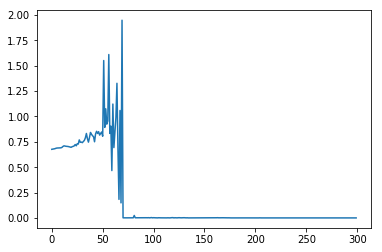

In [118]:
costs = np.reshape(costs, -1)
print(len(costs))
plt.plot(costs)